### Dataset: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score
from keras.models import load_model

In [ ]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/toxic comments/train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/toxic comments/test.csv")

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**No duplicates, no missing values**

In [ ]:
print(train.shape)
print(test.shape,'\n')
print(train.isnull().sum(),'\n')
print(test.isnull().sum(),'\n')

display(train[train.duplicated()])
display(test[test.duplicated()])

(159571, 8)
(153164, 2) 

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64 

id              0
comment_text    0
dtype: int64 



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


,id,comment_text


**Lets see some text and preprocess it: printing first 70 records**

In [ ]:
for i,txt in enumerate(train['comment_text']):
  if(i>70):
    break;
  print(i,txt,"\n","#######################################")

0 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27 
 #######################################
1 D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC) 
 #######################################
2 Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info. 
 #######################################
3 "
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date f

**In the pre-processing, after lematizing the words we will correct some short forms and abbreviations like hv, ur, i'm, you're, can't, don't etc. These are the short forms that we often use while typing loose comments. This sort of pre-processing is necessary otherwise tokenization will seperate can't to can and 't, you're to you  and 're and so on...**

In [ ]:
stop_words = stopwords.words('english') + list(punctuation)
word_lemetizer = WordNetLemmatizer()

def make_tokens(text):

    word = text.split()
    word = [w.lower() for w in word if w not in stop_words]
    word = [word_lemetizer.lemmatize(w).lower() for w in word]
    word = " ".join(word)
    
    word = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", word)
    word = re.sub(r"what's", "what is ", word)
    word = re.sub(r"\'s", " ", word)
    word = re.sub(r"\'ve", " have ", word)
    word = re.sub(r"\'re", " are ", word)
    word = re.sub(r"\'r", " your ", word)
    word = re.sub(r"can't", "cannot ", word)
    word = re.sub(r"don't", "do not ", word)
    word = re.sub(r"mustn't", "must not ", word)
    word = re.sub(r"shouldn't", "should not ", word)
    word = re.sub(r"haven't", "have not ", word)
    word = re.sub(r"i'm", "i am ", word)
    word = re.sub(r"\bi m\b", "i am ", word)
    word = re.sub(r"\bur\b", "your", word)
    word = re.sub(r"\bu\b", "you", word)
    word = re.sub(r"\bok\b", "okay", word)
    word = re.sub(r"\'re", " are ", word)
    word = re.sub(r"\'d", " would ", word)
    word = re.sub(r"\'ll", " will ", word)
    word = re.sub(r",", " ", word)
    word = re.sub(r"\.", " ", word)
    word = re.sub(r"!", " ! ", word)
    word = re.sub(r"\/", " ", word)
    word = re.sub(r"\^", " ^ ", word)
    word = re.sub(r"\+", " + ", word)
    word = re.sub(r"\-", " - ", word)
    word = re.sub(r"\=", " = ", word)
    word = re.sub(r"'", " ", word)
    word = re.sub(r":", " : ", word)
    word = re.sub(r" e g ", " eg ", word)
    word = re.sub(r"e - mail", "email", word)
    word = re.sub(r"\s{2,}", " ", word)

    word = RegexpTokenizer('[A-Za-z]+').tokenize(word)
    return word

**This is how it will look after pre-processing and cleaning. Again printing first 70 records:**

In [ ]:
for i,txt in enumerate(train["comment_text"]):
  if(i>70):
    break;
  print(i,make_tokens(txt),"\n","########################################")

0 ['explanation', 'why', 'edits', 'made', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'they', 'vandalisms', 'closure', 'gas', 'i', 'voted', 'new', 'york', 'doll', 'fac', 'and', 'please', 'remove', 'template', 'talk', 'page', 'since', 'i', 'am', 'retired', 'now'] 
 ########################################
1 ['d', 'aww', 'he', 'match', 'background', 'colour', 'i', 'am', 'seemingly', 'stuck', 'with', 'thanks', 'talk', 'january', 'utc'] 
 ########################################
2 ['hey', 'man', 'i', 'am', 'really', 'trying', 'edit', 'war', 'it', 'guy', 'constantly', 'removing', 'relevant', 'information', 'talking', 'edits', 'instead', 'talk', 'page', 'he', 'seems', 'care', 'formatting', 'actual', 'info'] 
 ########################################
3 ['more', 'i', 'cannot', 'make', 'real', 'suggestion', 'improvement', 'i', 'wondered', 'section', 'statistic', 'later', 'on', 'subsection', 'types', 'accidents', 'i', 'think', 'reference', 'may', 'need', 'tidying', 'exact', 'format',

**Now that we have seen what pre-processed and cleaned tokens would look like... lets actually do it on the whole dataset; training and testing both:**

In [ ]:
vocabulary = set()
for txt in train["comment_text"]:
    words = set(make_tokens(txt))
    vocabulary.update(words)
    
train["comment_tokens"] = train["comment_text"].apply(make_tokens)

In [ ]:
for txt in test["comment_text"]:
    words = set(make_tokens(txt))
    vocabulary.update(words)

vocabulary = list(vocabulary)
vocabulary.append("DUMMYWORD")
test["comment_tokens"] = test["comment_text"].apply(make_tokens)

In [ ]:
print("train set:")
display(train.head(10))
print("\ntest set:")
display(test.head(10))

train set:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_tokens
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"[explanation, why, edits, made, username, hard..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"[d, aww, he, match, background, colour, i, am,..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"[hey, man, i, am, really, trying, edit, war, i..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"[more, i, cannot, make, real, suggestion, impr..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"[you, sir, hero, any, chance, remember, page, ..."
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,"[congratulation, well, use, tool, well, talk]"
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,"[cocksucker, before, you, piss, around, on, my..."
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,"[your, vandalism, matt, shirvington, article, ..."
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,"[sorry, word, nonsense, offensive, you, anyway..."
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,"[alignment, subject, contrary, dulithgow]"



test set:


,id,comment_text,comment_tokens
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,"[yo, bitch, ja, rule, succesful, ever, whats, ..."
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,"[from, rfc, the, title, fine, is, imo]"
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...","[source, zawe, ashton, lapland]"
3,00017563c3f7919a,":If you have a look back at the source, the in...","[if, look, back, source, information, i, updat..."
4,00017695ad8997eb,I don't anonymously edit articles at all.,"[i, anonymously, edit, article, all]"
5,0001ea8717f6de06,Thank you for understanding. I think very high...,"[thank, understanding, i, think, highly, would..."
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...,"[please, add, nonsense, wikipedia, such, edits..."
7,000247e83dcc1211,:Dear god this site is horrible.,"[dear, god, site, horrible]"
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ...","[only, fool, believe, numbers, the, correct, n..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...,"[double, redirects, when, fixing, double, redi..."


In [ ]:
print("Total unique words in the vocabulary: ",len(vocabulary))

Total unique words in the vocabulary:  284097


In [ ]:
vocab2id = {w: i for i, w in enumerate(vocabulary)}

**Converting tokens to numbers, each token is represented by there position in the dictionary vocab2id**

In [ ]:
def convert_tokens_to_numbers(sentence_tokens):
  return [vocab2id[i] for i in sentence_tokens]

In [ ]:
train["comment_tokens"] = train["comment_tokens"].apply(convert_tokens_to_numbers)
test["comment_tokens"] = test["comment_tokens"].apply(convert_tokens_to_numbers)

In [ ]:
print("train set:")
display(train.tail(10))
print("\ntest set:")
display(test.tail(10))

train set:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_tokens
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0,"[181379, 134025, 118316, 3303, 184434, 63314, ..."
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0,"[265512, 134299, 233511, 34936, 47395, 271634,..."
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0,"[220961, 36579, 41250, 273318, 205815, 273318,..."
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0,"[278090, 159365, 171246, 198870, 115227, 18485..."
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0,"[50701, 137715, 266018, 80525, 178224, 249240,..."
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,"[228112, 10700, 142826, 140680, 48058, 75394, ..."
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,"[173278, 136872, 117041, 212127, 59909, 244405..."
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,"[22158, 282012, 242658, 274712, 46815, 187864,..."
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,"[228112, 170461, 65400, 99485, 244405, 97475, ..."
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0,"[228112, 3303, 185188, 244196, 115274, 3303, 2..."



test set:


,id,comment_text,comment_tokens
153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,"[251223, 130878, 173278, 19746, 276154, 225646..."
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,"[113146, 168059, 128676, 217704, 269010, 23107..."
153156,fffb5451268fb5ba,""" \n\n == Unicorn lair discovery == \n\n Suppo...","[84890, 176884, 206823, 175738, 84890, 176884,..."
153157,fffc2b34bbe61c8d,:Disagree. Soviet railways need their own arti...,"[55816, 75922, 15895, 18155, 46815, 42926, 172..."
153158,fffc489742ffe69b,This idiot can't even use proper grammar when ...,"[224835, 215054, 207614, 72189, 43792, 69799, ..."
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...","[104442, 243486, 128827, 223325, 147060, 17561..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,"[127760, 103798, 180866, 269664, 273794, 29684..."
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...","[196980, 16757, 3303, 56971, 49541, 243486, 16..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...","[39345, 216508, 257214, 130912, 187566, 166416..."
153163,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel...","[88462, 267870, 131702, 217165, 163987, 243314..."


**Seperating features from target, but before that some comments may have been removed (comments that only had stopwords and digits), hence lets see and drop those records from the training set:**

In [ ]:
print(len(train[train['comment_tokens'].map(len) <= 0]))
display(train[train['comment_tokens'].map(len) <= 0])

12


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_tokens
4482,0bed2196c873636d,1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...,0,0,0,0,0,0,[]
6300,10d0c3263b52a057,193.61.111.53 15:00,0,0,0,0,0,0,[]
17311,2db3383cc656e1a0,~ \n\n68.193.147.157,0,0,0,0,0,0,[]
23529,3e241552b0386ac4,between 1991 and 1999,0,0,0,0,0,0,[]
47072,7dc0ba6433d1c182,and then 70.8.194.249,0,0,0,0,0,0,[]
52442,8c4c53001134f290,"14:53,",0,0,0,0,0,0,[]
53787,8fb2aaf04e93061a,92.24.199.233|92.24.199.233]],0,0,0,0,0,0,[]
61758,a544b25e60599d48,"""\n\n 199.209.144.211 """,0,0,0,0,0,0,[]
82681,dd2be480f1027692,"""\n '''''' 2010/2013 """,0,0,0,0,0,0,[]
100782,1b6138b7f9fd87cb,"[24 and 25, after 23]",0,0,0,0,0,0,[]


**Clearly, we can see these 12 records wont really help in predicting so we can remove them**

In [ ]:
train = train[train['comment_tokens'].map(len) > 0]
print(train.shape)

(159559, 9)


In [ ]:
x = [i for i in train["comment_tokens"]]
y = np.array(train.iloc[:,2:8])

final_test = [i for i in test["comment_tokens"]]

In [ ]:
print("train set: ",len(x))
print("train labels: ",y.shape)
print("test set: ",len(final_test))

train set:  159559
train labels:  (159559, 6)
test set:  153164


**we dont have to transform y as it is already in the multilabel binarizer form**

In [ ]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

**lets see if we need to use a binary_crossentropy or categorical_crossentropy**

In [ ]:
c=1
for i in y:
  if(1 in i):
    print(i)
    c=c+1
    if(c>20):
      break;

[1 1 1 0 1 0]
[1 0 0 0 0 0]
[1 0 0 0 0 0]
[1 0 1 0 1 1]
[1 0 1 0 1 0]
[1 0 0 0 0 0]
[1 0 1 0 0 0]
[1 1 1 0 1 0]
[1 0 1 0 1 0]
[1 0 1 0 0 0]
[1 0 0 0 0 0]
[1 0 1 0 1 0]
[1 0 0 1 0 0]
[1 0 0 0 1 0]
[1 0 1 0 1 1]
[1 0 0 0 0 0]
[1 0 0 0 0 0]
[1 0 0 0 1 0]
[1 0 1 1 1 1]
[0 0 0 0 1 0]


**As we can see that each datapoint can belong to multiple classes hence this is multilabel classification i.e each datapoint can have multiple classes. To deal with this kind of classification we use binary_crossentropy
read this: https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451 --- and --- https://www.researchgate.net/post/What_is_the_difference_between_multiple_outputs_and_multilabel_output#:~:text=Multiclass%20classification%20makes%20the%20assumption,a%20set%20of%20target%20labels.&text=The%20set%20of%20labels%20can%20be%20different%20for%20each%20output%20variable<br><br>Now we have to do the padding since the comments/sentences might be of variable lengths but the inputs of the neural network are always of fixed lengths.
<br>Lets plot and see what the lengths of the sentences are in the train set:**

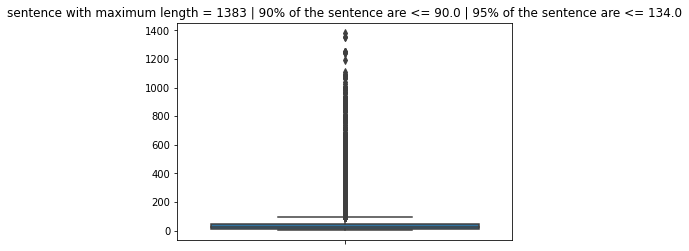

In [ ]:
lengths_train = [len(i) for i in train["comment_tokens"]] 
percentile90 = np.percentile(a=lengths_train, q=90)
percentile95 = np.percentile(a=lengths_train, q=95)
sns.boxplot(y=lengths_train).set_title("sentence with maximum length = {} | 90% of the sentence are <= {} | 95% of the sentence are <= {}".format(max(lengths_train),percentile90,percentile95))
plt.show()

**We can see the maximum length of the comment is 1354 while 90% of the sentences are either 90 or less than 90 and 95% of the sentences are either 134 or less than 134<br>
We can pad to the maximum length but then the lstm cell will have to be very large to store the states. If we pad to less than 1354 then it might happen that some inportant information may get lost since those sentences will be cut short.<br>
Since 95% of the sentences are 134 or less than 134, hence 134 seems to be a fair choice. All the sentences shorter than 134 will be padded to be be 134, whilst all the sentences longer than 134 will be cut short to 134**

In [ ]:
len(vocabulary)

284097

**Words in x are encoded between 0 to 284096, to pad words we will use 284097 as the value i.e padded words will be represented by 284097. This also happens to be the length of the vocabulary<br>We will pad both test and train sets:**

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_padded = pad_sequences(maxlen=134, sequences=x, padding="post", value=len(vocabulary))
finaltest_padded = pad_sequences(maxlen=134, sequences=final_test, padding="post", value=len(vocabulary))

In [ ]:
print(x_padded.shape)
print(finaltest_padded.shape)

(159559, 134)
(153164, 134)


In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(x_padded, y, test_size=0.25)

print(x_tr.shape)
print(x_te.shape)

(119669, 134)
(39890, 134)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input,GlobalMaxPool1D

In [ ]:
print(x_padded.max())

284097


**x_padded has values from 0 to 284097 i.e total vocab size is 284098**<br>
# Model 1

In [ ]:
input = Input(shape=(134,),batch_size=None)
model = Embedding(input_dim=len(vocabulary)+1, output_dim=100, input_length=200)(input)
model = Dropout(0.1)(model)
model = LSTM(units=70, return_sequences=False, recurrent_dropout=0.1)(model)
# model = GlobalMaxPool1D()(model)
model = Dense(50, activation="relu")(model)
model = Dropout(0.1)(model)
out = Dense(6, activation="sigmoid")(model)
model = Model(input, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 134)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 134, 100)          28409800  
_________________________________________________________________
dropout (Dropout)            (None, 134, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 70)                47880     
_________________________________________________________________
dense (Dense)                (None, 50)                3550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
stop = EarlyStopping(monitor='loss', min_delta=0.01, patience=2, verbose=1, mode='min', restore_best_weights=True)
model.fit(x_tr, y_tr, batch_size=32, epochs=5, validation_split=0.1, verbose=1, callbacks=[stop])

Epoch 1/5
3366/3366 [==============================] - 2235s 664ms/step - loss: 0.1424 - accuracy: 0.9151 - val_loss: 0.1215 - val_accuracy: 0.9943
Epoch 2/5
3366/3366 [==============================] - 2137s 635ms/step - loss: 0.1263 - accuracy: 0.9906 - val_loss: 0.1057 - val_accuracy: 0.9943
Epoch 3/5
3366/3366 [==============================] - 2097s 623ms/step - loss: 0.1047 - accuracy: 0.9939 - val_loss: 0.1086 - val_accuracy: 0.9943
Epoch 4/5
3366/3366 [==============================] - 2066s 614ms/step - loss: 0.1007 - accuracy: 0.9940 - val_loss: 0.0913 - val_accuracy: 0.9943
Epoch 5/5
3366/3366 [==============================] - 2063s 613ms/step - loss: 0.0893 - accuracy: 0.9941 - val_loss: 0.0831 - val_accuracy: 0.9943


In [ ]:
# model.save("/content/drive/My Drive/Colab Notebooks/toxic comments/model1.h5")

Testing set accuracy:

In [ ]:
# m1 = load_model("/content/drive/My Drive/Colab Notebooks/toxic comments/model1.h5")

In [ ]:
m1.evaluate(x_te, y_te)

1247/1247 [==============================] - 33s 27ms/step - loss: 0.3029 - accuracy: 0.9944


**Finally lets predict on the main kaggle test set:
<br>SCORE: 91.14% AUC**

In [ ]:
preds = model.predict(finaltest_padded)
preds.shape

(153164, 6)

In [ ]:
labels = list(train.columns)[2:8]
submid = pd.DataFrame({'id': test["id"]})
submit = pd.concat([submid, pd.DataFrame(preds, columns=labels)], axis=1)
# submit.to_csv('/content/drive/My Drive/Colab Notebooks/toxic comments/submission1.csv',index=False) 

# Model 2
Same as model 1, just added the bidirectional layer

In [ ]:
input = Input(shape=(134,),batch_size=None)
model = Embedding(input_dim=len(vocabulary)+1, output_dim=100, input_length=200)(input)
model = Bidirectional(LSTM(units=70, return_sequences=False, recurrent_dropout=0.1))(model)
model = Dense(50, activation="relu")(model)
model = Dropout(0.1)(model)
out = Dense(6, activation="sigmoid")(model)
model = Model(input, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 134)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 134, 100)          28409800  
_________________________________________________________________
bidirectional (Bidirectional (None, 140)               95760     
_________________________________________________________________
dense (Dense)                (None, 50)                7050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 28,512,916
Trainable params: 28,512,916
Non-trainable params: 0
__________________________________________

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1, mode='min', restore_best_weights=True)
model.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_split=0.1, verbose=1, callbacks=[stop])

Epoch 1/10
3366/3366 [==============================] - 3422s 1s/step - loss: 0.0669 - accuracy: 0.9270 - val_loss: 0.0485 - val_accuracy: 0.9936
Epoch 2/10
3366/3366 [==============================] - 3385s 1s/step - loss: 0.0422 - accuracy: 0.9888 - val_loss: 0.0491 - val_accuracy: 0.9936
Epoch 3/10
3366/3366 [==============================] - 3372s 1s/step - loss: 0.0347 - accuracy: 0.9865 - val_loss: 0.0525 - val_accuracy: 0.9921
Epoch 00003: early stopping


In [ ]:
# model.save("/content/drive/My Drive/Colab Notebooks/toxic comments/model2.h5")

Testing set accuracy:

In [ ]:
# m2 = load_model("/content/drive/My Drive/Colab Notebooks/toxic comments/model2.h5")

In [ ]:
m2.evaluate(x_te, y_te)

1247/1247 [==============================] - 63s 50ms/step - loss: 0.2815 - accuracy: 0.9944


**Again lets predict on the main kaggle test set:
<br>SCORE: 96.54% AUC**

In [ ]:
preds = model.predict(finaltest_padded)
preds.shape

(153164, 6)

In [ ]:
labels = list(train.columns)[2:8]
submid = pd.DataFrame({'id': test["id"]})
submit = pd.concat([submid, pd.DataFrame(preds, columns=labels)], axis=1)
# submit.to_csv('/content/drive/My Drive/Colab Notebooks/toxic comments/submission2.csv',index=False) 

# Results:
Amazing to see how bi-directional layer improved the predictions so much. With just this layer the kaggle set AUC score went up by 5.4%